In [20]:
from sklearn.manifold import TSNE
import h5py
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [21]:
# From https://wjddyd66.github.io/pytorch/Pytorch-AutoEncoder/
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        dropout = torch.nn.Dropout(p=0.5)
        self.layer1 = nn.Sequential(
            nn.Linear(6714, 4096),  # batch x 16 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 2048),  # batch x 32 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),  # batch x 32 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(1024)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),  # batch x 16 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),  # batch x 32 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),  # batch x 32 x 28 x 28
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [22]:
# From https://wjddyd66.github.io/pytorch/Pytorch-AutoEncoder/
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        dropout = torch.nn.Dropout(p=0.5)
        self.layer1 = nn.Sequential(
            nn.Linear(128, 256),  # batch x 16 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),  # batch x 32 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),  # batch x 32 x 28 x 28
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 2048),  # batch x 16 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 4096),  # batch x 32 x 28 x 28
            nn.ReLU(),
            dropout,
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 6714),  # batch x 32 x 28 x 28
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [23]:
encoder, decoder = torch.load('./models/Feature_AE_dropout_model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class CursinePredictDataset(Dataset):
    def __init__(self, file_path, transform=None):
        h5f = h5py.File(file_path, "r")
        self.ingredients = h5f['features_one_hot'][:]
        self.cursine = h5f['labels_int_enc'][:]
        h5f.close()
        self.transform = transform
        
    def __len__(self):
        return len(self.cursine)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ingredients = torch.FloatTensor(self.ingredients[idx])
        cursine = torch.FloatTensor([self.cursine[idx]])
        sample = (ingredients, cursine)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [25]:
batch_size = 64

trainset = CursinePredictDataset("./Container/train")
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [27]:
features = []
embs = []
preds = []
labels = []

for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    features.extend(np.array(data.cpu()))
    labels.extend(np.array(target.cpu()))
    output = encoder(data)
    embs.extend(output.cpu().detach().numpy())

In [34]:
labels

[array([6.], dtype=float32),
 array([4.], dtype=float32),
 array([18.], dtype=float32),
 array([12.], dtype=float32),
 array([19.], dtype=float32),
 array([16.], dtype=float32),
 array([7.], dtype=float32),
 array([4.], dtype=float32),
 array([4.], dtype=float32),
 array([3.], dtype=float32),
 array([6.], dtype=float32),
 array([12.], dtype=float32),
 array([6.], dtype=float32),
 array([4.], dtype=float32),
 array([3.], dtype=float32),
 array([13.], dtype=float32),
 array([12.], dtype=float32),
 array([4.], dtype=float32),
 array([9.], dtype=float32),
 array([11.], dtype=float32),
 array([12.], dtype=float32),
 array([4.], dtype=float32),
 array([16.], dtype=float32),
 array([3.], dtype=float32),
 array([7.], dtype=float32),
 array([4.], dtype=float32),
 array([13.], dtype=float32),
 array([10.], dtype=float32),
 array([8.], dtype=float32),
 array([3.], dtype=float32),
 array([13.], dtype=float32),
 array([11.], dtype=float32),
 array([6.], dtype=float32),
 array([3.], dtype=float32),


In [33]:
n_components = 2

model = TSNE(n_components=n_components)
result = model.fit_transform(embs)

C:\Users\kami.DESKTOP-5P4EH18\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kami.DESKTOP-5P4EH18\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import numpy.linalg as LA
import pickle
import numpy as np

with open('./container/id_cursine_dict.pickle', 'rb') as fr:
    id_cursine_dict = pickle.load(fr)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
C:\Users\kami.DESKTOP-5P4EH18\AppData\Local\Temp\ipykernel_15756\3246734108.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  temp_fig.show()
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence

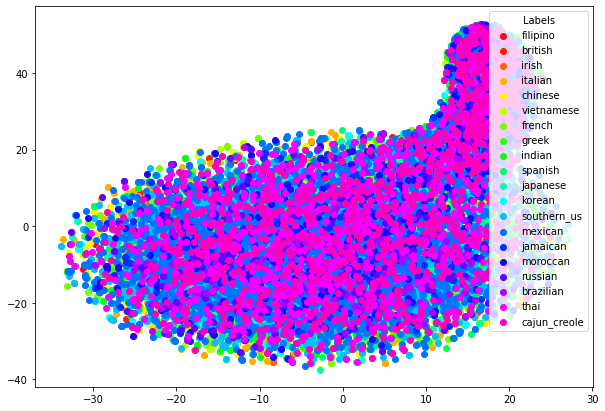

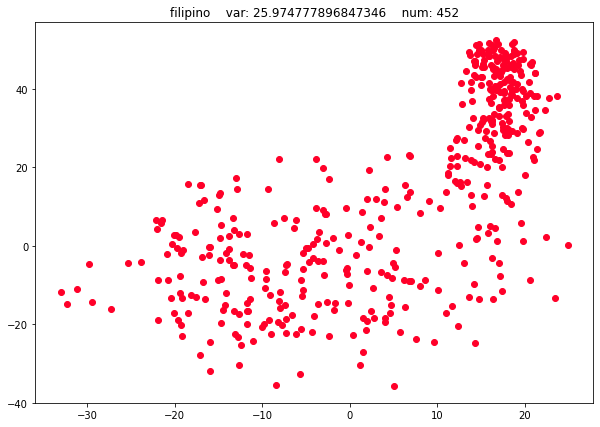

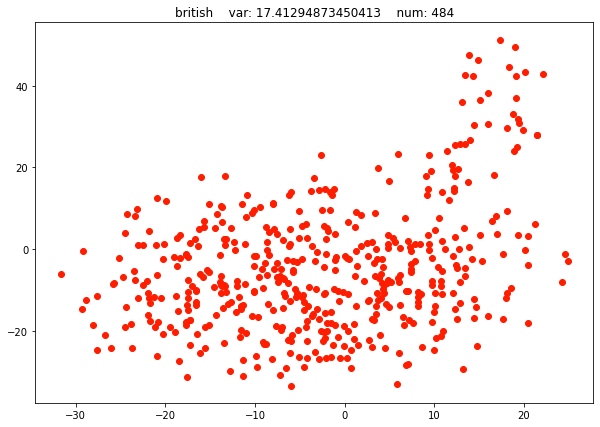

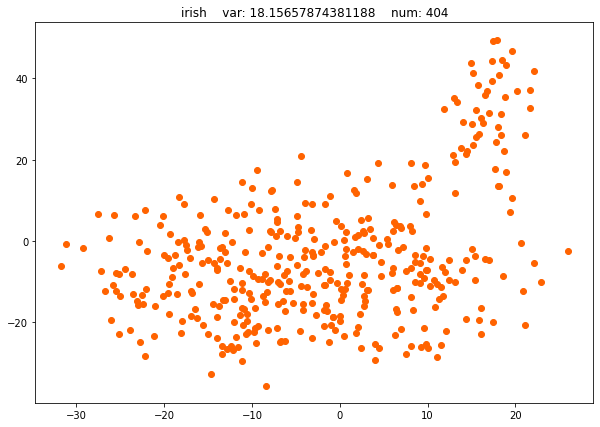

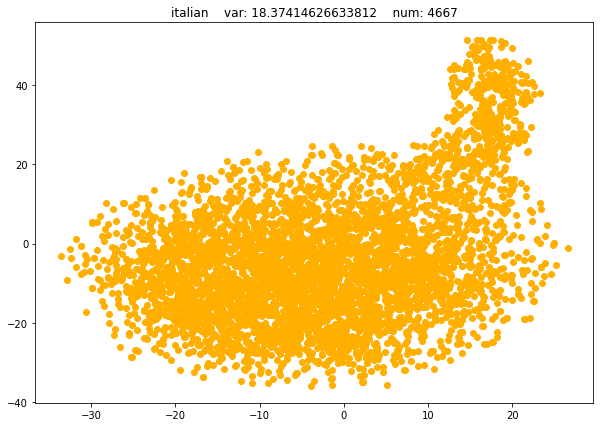

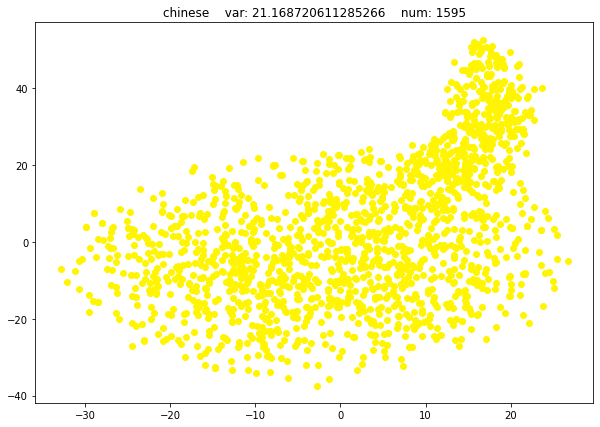

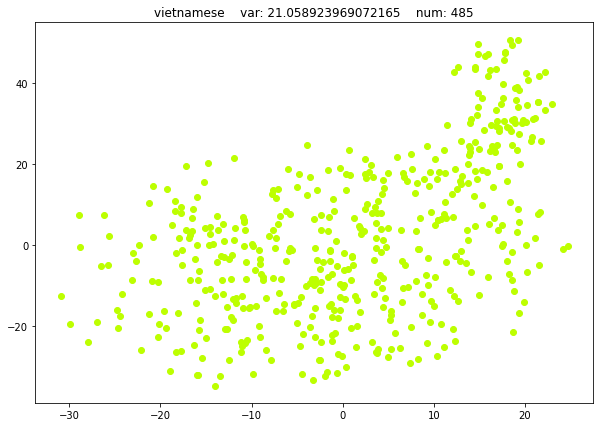

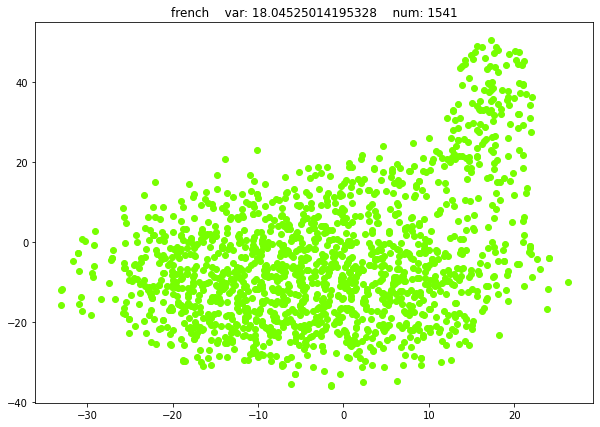

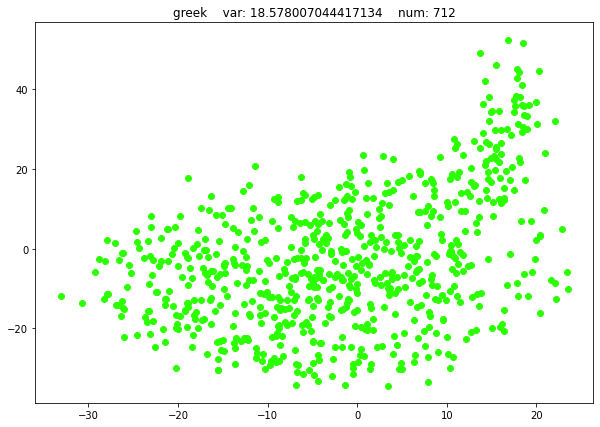

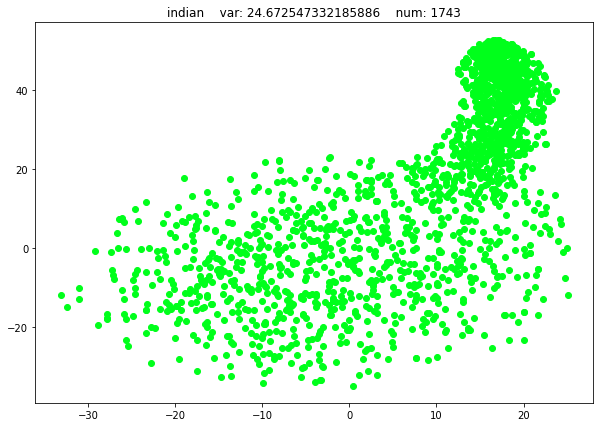

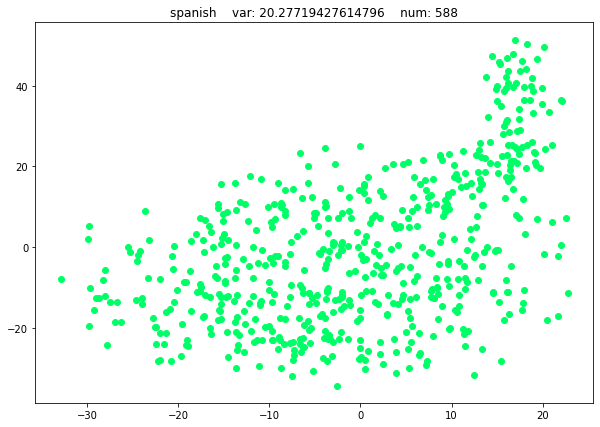

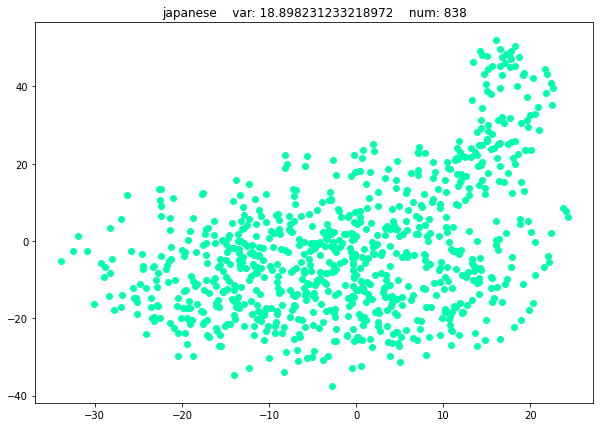

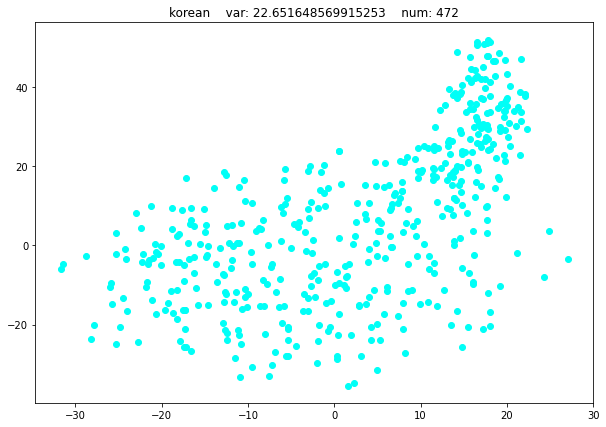

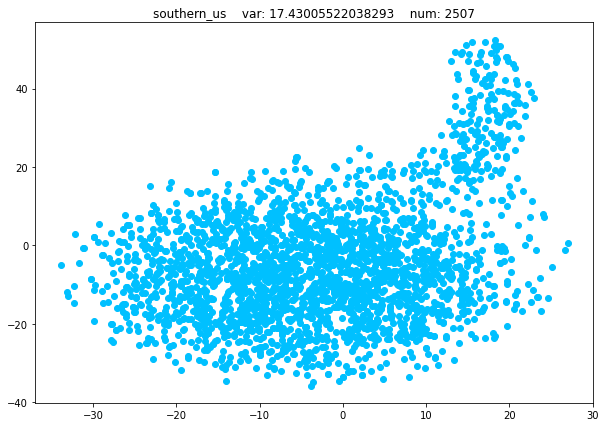

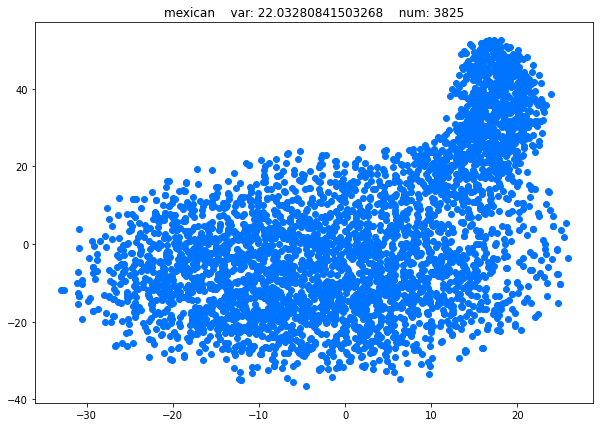

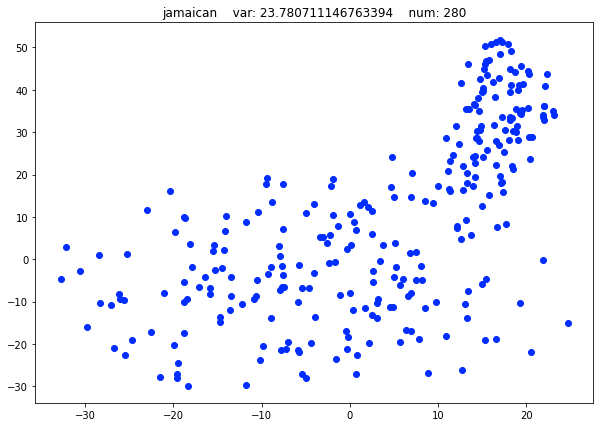

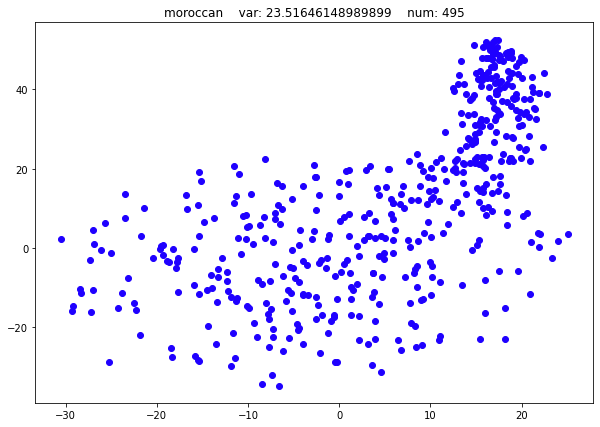

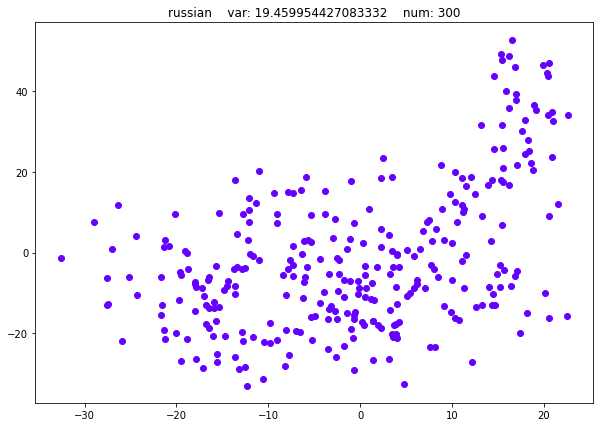

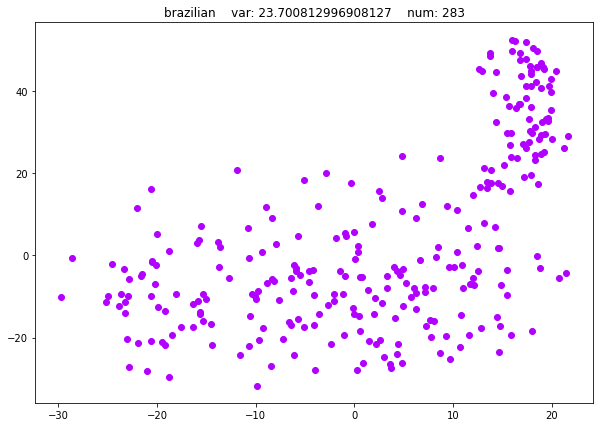

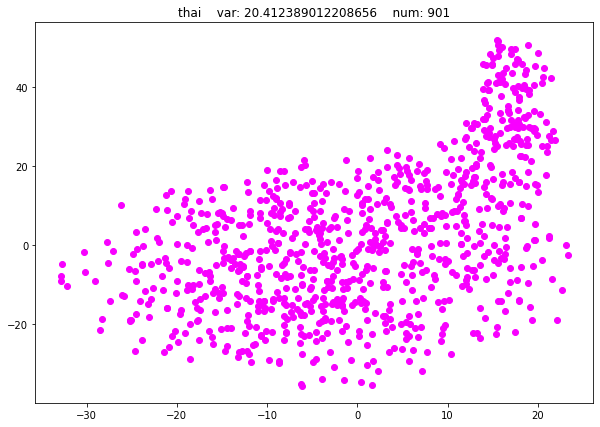

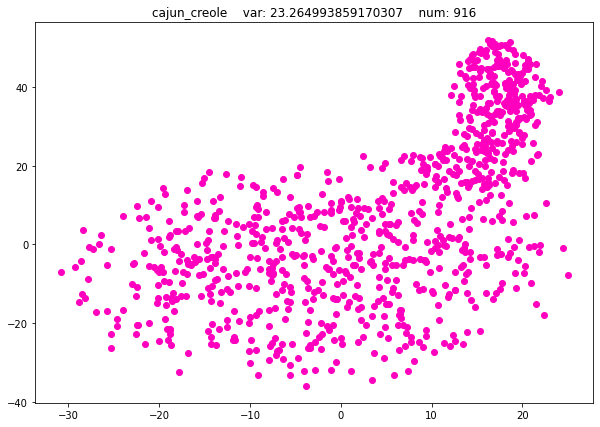

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=20-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_cycle = [scalarMap.to_rgba(i) for i in range(20)]
ax.set_prop_cycle(color=color_cycle)

labels = np.array(labels).flatten()

for i in range(20):
    idx = np.where(labels == i)
    temp_fig, temp_ax = plt.subplots()
    temp_fig.set_size_inches(10, 7)
    temp_ax.scatter(result[idx,0], result[idx,1], c=color_cycle[i], label=id_cursine_dict[i])
    ax.scatter(result[idx,0], result[idx,1], label=id_cursine_dict[i])
    x_avg = np.average(result[idx,0])
    y_avg = np.average(result[idx,1])
    diff = result[idx] - (x_avg, y_avg)
    variance = np.sum(LA.norm(diff, axis=1))/len(idx[0])
    #print(id_cursine_dict[i], variance)
    temp_ax.set_title(id_cursine_dict[i] + "    var: {}    num: {}".format(variance, len(idx[0])))
    temp_fig.show()
    temp_fig.savefig('./Data_analysis/tsne_AE_Feature_{}.png'.format(id_cursine_dict[i]), dpi=100)

ax.legend(loc="upper right", title="Labels")
fig.savefig('./Data_analysis/tsne_AE_Feature.png', dpi=100)